In [28]:
# packages
import numpy as np
import pandas as pd
import random
import os

# database
import yfinance as yf
from sqlalchemy import create_engine, inspect

# quadratic
import quadprog
from scipy.optimize import minimize

# visualisation
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from tabulate import tabulate


# maybe
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

/Users/jackstevenson/CQF/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Data & Pre-Processing

In [25]:
# manually acquire factor data from f&f site
def generate_fama_factor_df():
    factor_df = pd.read_csv('/Users/jackstevenson/CQF/Project/F-F_Research_Data_5_Factors_2x3_daily.csv')

    factor_df['Date'] = pd.to_datetime(factor_df['Date'], format='%Y%m%d')

    factor_df = factor_df.set_index('Date')

    # align our data with start date 
    factor_df = factor_df[factor_df.index >= '2010-09-27']

    factor_df.rename(columns={
        'SMB': 'Factor SMB', # small business
        'HML': 'Factor HML', # value 
        'RMW': 'Factor RMW', # robust vs weak
        'CMA': 'Factor CMA' # conversative minus aggressive
        }, inplace=True)

    factor_df.drop(columns=['Mkt-RF', 'RF'], axis=1,  inplace=True)

    factor_df = factor_df / 100

    return factor_df

In [26]:
# create the database
df = yf.download('IYE IYM IYJ IYC IYK IYH IYF IYW IYZ IDU IYR ^IRX ^VIX ^BCOM AGG ^SPX', start='2010-09-24', end='2024-06-30')['Close']

# add the factor data and concatenate
factor_df = generate_fama_factor_df()

df = pd.concat([df, factor_df], axis=1)

df.rename(columns={
    'IYE': 'Energy',
    'IYM': 'Materials',
    'IYJ': 'Industrials',
    'IYC': 'Consumer Discretionary',
    'IYK': 'Consumer Staples',
    'IYH': 'Health Care',
    'IYF': 'Financials',
    'IYW': 'Information Technology',
    'IYZ': 'Communication Services',
    'IDU': 'Utilities',
    'IYR': 'Real Estate',
    '^IRX':'3M TB',
    '^VIX': 'Volatility (Exo)',
    '^BCOM': 'Commodities (Exo)',
    'AGG': 'Bonds (Exo)',
    '^SPX': 'Benchmark - S&P 500'
    }, inplace=True)

# # reset index
df.reset_index(inplace=True)

# # create our engine
engine = create_engine("sqlite:///project_portfolio.db")

# # if_exits will overwrite the pre-existing table
df.to_sql('portfolio_data', engine, if_exists='replace', index=False)

NameError: name 'yf' is not defined

In [29]:
# create our engine
engine = create_engine("sqlite:///project_portfolio.db")

df = pd.read_sql('portfolio_data', con=engine)

# # set date as index
df.set_index('Date', inplace=True)

# create separate t bill dataframe
three_month_tbill = df['3M TB'] / 252

# create separate benchmark dataframe
benchmark_spx_500 = df['Benchmark - S&P 500'].pct_change()

# consistent ordering
df = df[['Energy', 'Materials', 'Industrials', 'Consumer Discretionary', 'Consumer Staples', 'Health Care', 'Financials', 'Information Technology', 
         'Communication Services', 'Utilities', 'Real Estate', 'Volatility (Exo)', 'Commodities (Exo)', 'Bonds (Exo)', 'Factor SMB', 'Factor HML', 
         'Factor RMW', 'Factor CMA']]

# calculate simple returns
simple_returns = df.drop(columns=['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']).pct_change()

simple_returns = pd.concat([simple_returns, df[['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']]], axis=1)

/var/folders/3z/lz8knlfn5ys693qpn6bnjb440000gn/T/ipykernel_4571/3435988170.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  simple_returns = df.drop(columns=['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']).pct_change()


#### Custom Factor - Momentum Factor

In [30]:
# lookback period 252 (approximate 12 months)
lookback_period = 252

# exclude the exogenous and fama-french
sector_momentum = simple_returns.drop(columns=['Volatility (Exo)', 'Commodities (Exo)', 
                                               'Bonds (Exo)','Factor SMB', 'Factor HML', 
                                               'Factor RMW', 'Factor CMA']).rolling(window=lookback_period).apply(lambda x: (x + 1).prod() - 1)

# rank the sector returns over lookback plus lag to prevent perfect portfolio
momentum_ranks = sector_momentum.rank(axis=1, method='first', ascending=False).shift(1).dropna()

# identify top and bottom
top_momentum_sectors = momentum_ranks <= 3  # Top 3 sectors
bottom_momentum_sectors = momentum_ranks >= 9  # Bottom 3 sectors

# construct portfolio returns from top & bottom
momentum_high_portfolio = simple_returns[top_momentum_sectors].mean(axis=1)
momentum_low_portfolio = simple_returns[bottom_momentum_sectors].mean(axis=1)

# calculate momentum factor returns
momentum_factor_return = momentum_high_portfolio - momentum_low_portfolio
momentum_factor_return_df = momentum_factor_return.to_frame(name='Factor MOM')

# add into simple_returns_df
simple_returns = pd.concat([simple_returns, momentum_factor_return_df], axis=1)

# drop the first 12 months due to lookback
simple_returns.dropna(inplace=True)

In [31]:
# subtract the 3m t bill daily rate
excess_returns = simple_returns.sub(three_month_tbill, axis=0)

# calculate log returns returns
log_returns = np.log(1 + simple_returns).dropna()

In [32]:
# common date index
common_index = log_returns.index.intersection(benchmark_spx_500.index)

# split the index between backtesting and post optimisation periods
backtesting_index = common_index[common_index < '2022-01-01']
post_optimisation_index = common_index[common_index >= '2022-01-01']

# filter for index
log_returns_back_testing = log_returns.loc[backtesting_index]
benchmark_spx_500_back_testing = benchmark_spx_500.loc[backtesting_index]

#### Black-Litterman Class Model

In [33]:
class BlackLittermanModel:
    def __init__(self, equilibrium_weights, log_returns, risk_aversion, views_mapping_matrix, views_matrix, tracking_error_target=0.0001, tau=0.025):
        self._equilibrium_weights = equilibrium_weights
        self._log_returns = log_returns
        self._risk_aversion = risk_aversion
        self._tau = tau
        self._covariance_matrix = self._calculate_covariance_matrix()
        self._views_mapping_matrix = views_mapping_matrix
        self._views_matrix = views_matrix
        self._tracking_error_target = tracking_error_target 

    # TODO: private methods
    def _calculate_covariance_matrix(self):
        # calculate the vols
        volatilities_array = self._log_returns.std()

        # calculate correlation
        correlation_coefficients = self._log_returns.corr()

        # create the diagonal vol matrix (vol on the diagonal, zeros elsewhere)
        std_diag_vol_matrix  = np.diag(volatilities_array)

        # compute the covariance matrix
        covariance_matrix = std_diag_vol_matrix @ correlation_coefficients.values @ std_diag_vol_matrix

        # pass the headers from log return 

        covariance_matrix = pd.DataFrame(
            covariance_matrix,
            columns = self._log_returns.columns,
            index = self._log_returns.columns,
        )

        return covariance_matrix
    
    def calculate_views_adjusted_returns(self):
        # we need implied equity returns and omega
        implied_returns_vector = self.calculate_implied_equilibrium_returns().values

        omega = self.calculate_uncertainty_views_matrix()

        # we have three terms for the np.dot product
        tau_sigma_transpose_p = self._tau * (self._covariance_matrix.values @ self._views_mapping_matrix.T)

        inverse_middle_term = np.linalg.inv((self._views_mapping_matrix @ tau_sigma_transpose_p) + omega)

        view_minus_p = (self._views_matrix - (self._views_mapping_matrix @ implied_returns_vector))

        views_adjusted_returns_vector = implied_returns_vector + ((tau_sigma_transpose_p @ inverse_middle_term) @ view_minus_p)

        # convert to dataframe for consistency
        views_adjusted_returns = pd.DataFrame(views_adjusted_returns_vector, columns=["Adjusted Return"], index=self._log_returns.columns)

        return views_adjusted_returns
    
    # calculate the covariance of the error terms aka omega
    def calculate_uncertainty_views_matrix(self):
        # you extract the diagonal and then convert to a diagonal matrix with zeros
        omega = np.diag(((self._views_mapping_matrix @ (self._tau * self._covariance_matrix)) @ self._views_mapping_matrix.T))
        
        return np.diag(omega)

    
    def calculate_implied_equilibrium_returns(self):
        implied_returns_vector = self._risk_aversion * (self._covariance_matrix @ self._equilibrium_weights)

        implied_returns = pd.DataFrame(implied_returns_vector, columns=["Implied Return"], index=self._log_returns.columns)

        return implied_returns
    
    def calculate_unconstrained_mv_optimisation(self):
        # invert the covariance matrix
        inv_cov_matrix = np.linalg.inv(self._covariance_matrix)

        # calculate adjusted returns
        adjusted_returns = self.calculate_views_adjusted_returns().values

        # obtain weights
        optimal_weights = self._risk_aversion * np.dot(inv_cov_matrix, adjusted_returns)

        # # normalise the sum of weights to 1
        optimal_weights /= np.sum(optimal_weights)

        # convert to dataframe for consistency
        optimal_weights = pd.DataFrame(optimal_weights, columns=["Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    def generate_mv_constraint_matrices(self, implied_returns_vector_values):
        # we will generate our two constraints - no short selling & no leverage
        number_of_assets = len(implied_returns_vector_values)

        # no short selling
        no_short_selling_constraint_coefficient = np.eye(number_of_assets)
        no_short_selling_constraint_rhs = np.zeros(number_of_assets)

        # no leverage - you need to transpose the 
        no_leverage_constraint_coefficient = np.ones([1, number_of_assets])
        no_leverage_constraint_rhs = np.array([1.0])

        # stack them together
        C_constraint_matrix = np.vstack([no_leverage_constraint_coefficient, no_short_selling_constraint_coefficient])
        b_constraint_matrix = np.hstack([no_leverage_constraint_rhs, no_short_selling_constraint_rhs])

        return C_constraint_matrix, b_constraint_matrix
    
        
    def calculate_constrained_mv_optimisation(self):
        implied_returns_vector_values = self.calculate_implied_equilibrium_returns().values

        # we are solving an equation of the form - 1/2 x^T G x - a^T x s.t. C.T x >= b
        quadratic_G = self.risk_aversion * self._covariance_matrix.values

        quadratic_a = self.calculate_views_adjusted_returns().values.flatten()

        # generate constraints
        C_constraint_matrix, b_constraint_matrix = self.generate_mv_constraint_matrices(implied_returns_vector_values)

        # solve for weights
        optimal_weights = quadprog.solve_qp(quadratic_G, quadratic_a, C_constraint_matrix.T, b_constraint_matrix, meq=1)[0]

        optimal_weights = pd.DataFrame(optimal_weights, columns=["Constrained Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    
    def calculate_tracking_error_optimisation(self):
        implied_returns_vector_values = self.calculate_implied_equilibrium_returns().values

        number_of_assets = len(implied_returns_vector_values)

        adjusted_returns = self.calculate_views_adjusted_returns().values

        # constraints
        constraints = [{'type': 'eq', 'fun': self.zero_sum_equality_constraint},
                       {'type': 'eq', 'fun': self.tracking_error_target_constraint}]
        

        # bounds - no short selling or other constraints
        bounds = [(None, None)] * number_of_assets

        # initial guess - very small non-zero deviation
        x0 = np.ones(number_of_assets) * 1e-3

        # generate weights
        results = minimize(fun= self.objective_function, x0=x0, bounds=bounds, constraints=constraints)
        
        if not results.success:
            print("Optimization failed:", results.message)
            return None

        optimal_deviations = results.x

        # create a series from the deviations with the same index as the eq weights
        optimal_deviations = pd.Series(results.x, index=self._equilibrium_weights.index)

        optimal_weights = self._equilibrium_weights + optimal_deviations

        optimal_weights = pd.DataFrame(optimal_weights, columns=["TE Constrained Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    # Tracking Error - objective and constraints
    def objective_function(self, x):
        # maximise returns
        adjusted_returns = self.calculate_views_adjusted_returns().values
        value = - np.dot(x, adjusted_returns)
        # print(f"Objective function value: {value} for x: {x}")


        return value
    
    def zero_sum_equality_constraint(self, x):
        # constraint - sum of deviations is zero
        value = np.sum(x)
        # print(f"Zero sum constraint value: {value} for x: {x}")

        return value
    
    def tracking_error_target_constraint(self, x):
        value = np.dot(x.T, np.dot(self.covariance_matrix, x)) - self._tracking_error_target
        # print(f"Tracking error constraint value: {value} for x: {x}")

        return value


    # attributes
    # tau
    @property
    def tau(self):
        return self._tau

    @tau.setter
    def tau(self, value):
        self._tau = value

    # risk aversion 
    @property
    def risk_aversion(self):
        return self._risk_aversion

    @risk_aversion.setter
    def risk_aversion(self, value):
        self._risk_aversion = value

    @property
    def covariance_matrix(self):
        return self._covariance_matrix

#### Model Parameters

In [34]:
sector_weights = pd.Series({
    'Energy': 0.037,
    'Materials': 0.026,
    'Industrials': 0.08,
    'Consumer Discretionary': 0.118,
    'Consumer Staples': 0.062,
    'Health Care': 0.1330,
    'Financials': 0.1150,
    'Information Technology': 0.281,
    'Communication Services': 0.096,
    'Utilities': 0.026,
    'Real Estate': 0.026
})

# adjust for portfolio weight
sector_weights = sector_weights * 0.92

factors_and_exo_weighs = pd.Series({
    'Volatility (Exo)': 0.01,
    'Commodities (Exo)': 0.01,
    'Bonds (Exo)': 0.01,
    'Factor SMB': 0.01,
    'Factor HML': 0.01,
    'Factor RMW': 0.01,
    'Factor CMA': 0.01,
    'Factor MOM': 0.01
})

# portfolio weights in equilibirum
equilibrium_weights = pd.concat([sector_weights, factors_and_exo_weighs])

# risk aversion
risk_aversion_dict = pd.Series({
    # in order of increasing aversion
    'Kelly': 0.01,
    'Market': 2.24,
    'Trustee': 6
})

#### Views Matrices - P & Q

In [35]:
# view adjusted returns with defined views
k = 3
n = len(equilibrium_weights)

#  these are annual views so we need to divide by 252 to make them daily
Q = np.array([0.065, 0.001, 0.005]).reshape(-1, 1) / 252

P = np.zeros((k, n))

# bl_model.calculate_views_adjusted_returns()

# first view
P[0, 0] = 1 # energy

# second view
P[1, 6] = -1 # info technology
P[1, 7] = 1 # financials

# third view
P[2, 1] = -0.1804 # materials
P[2, 3] = -0.8196 # cons discretionary
P[2, 4] = 0.3177 # cons staples
P[2, 5] = 0.6823 # healthcare

#### Initialise Black-Litterman Model

In [36]:
bl_model = BlackLittermanModel(equilibrium_weights, log_returns_back_testing, risk_aversion_dict['Market'], P, Q)

#### Fig. 1 - Portfolio Factor Correlation Matrix

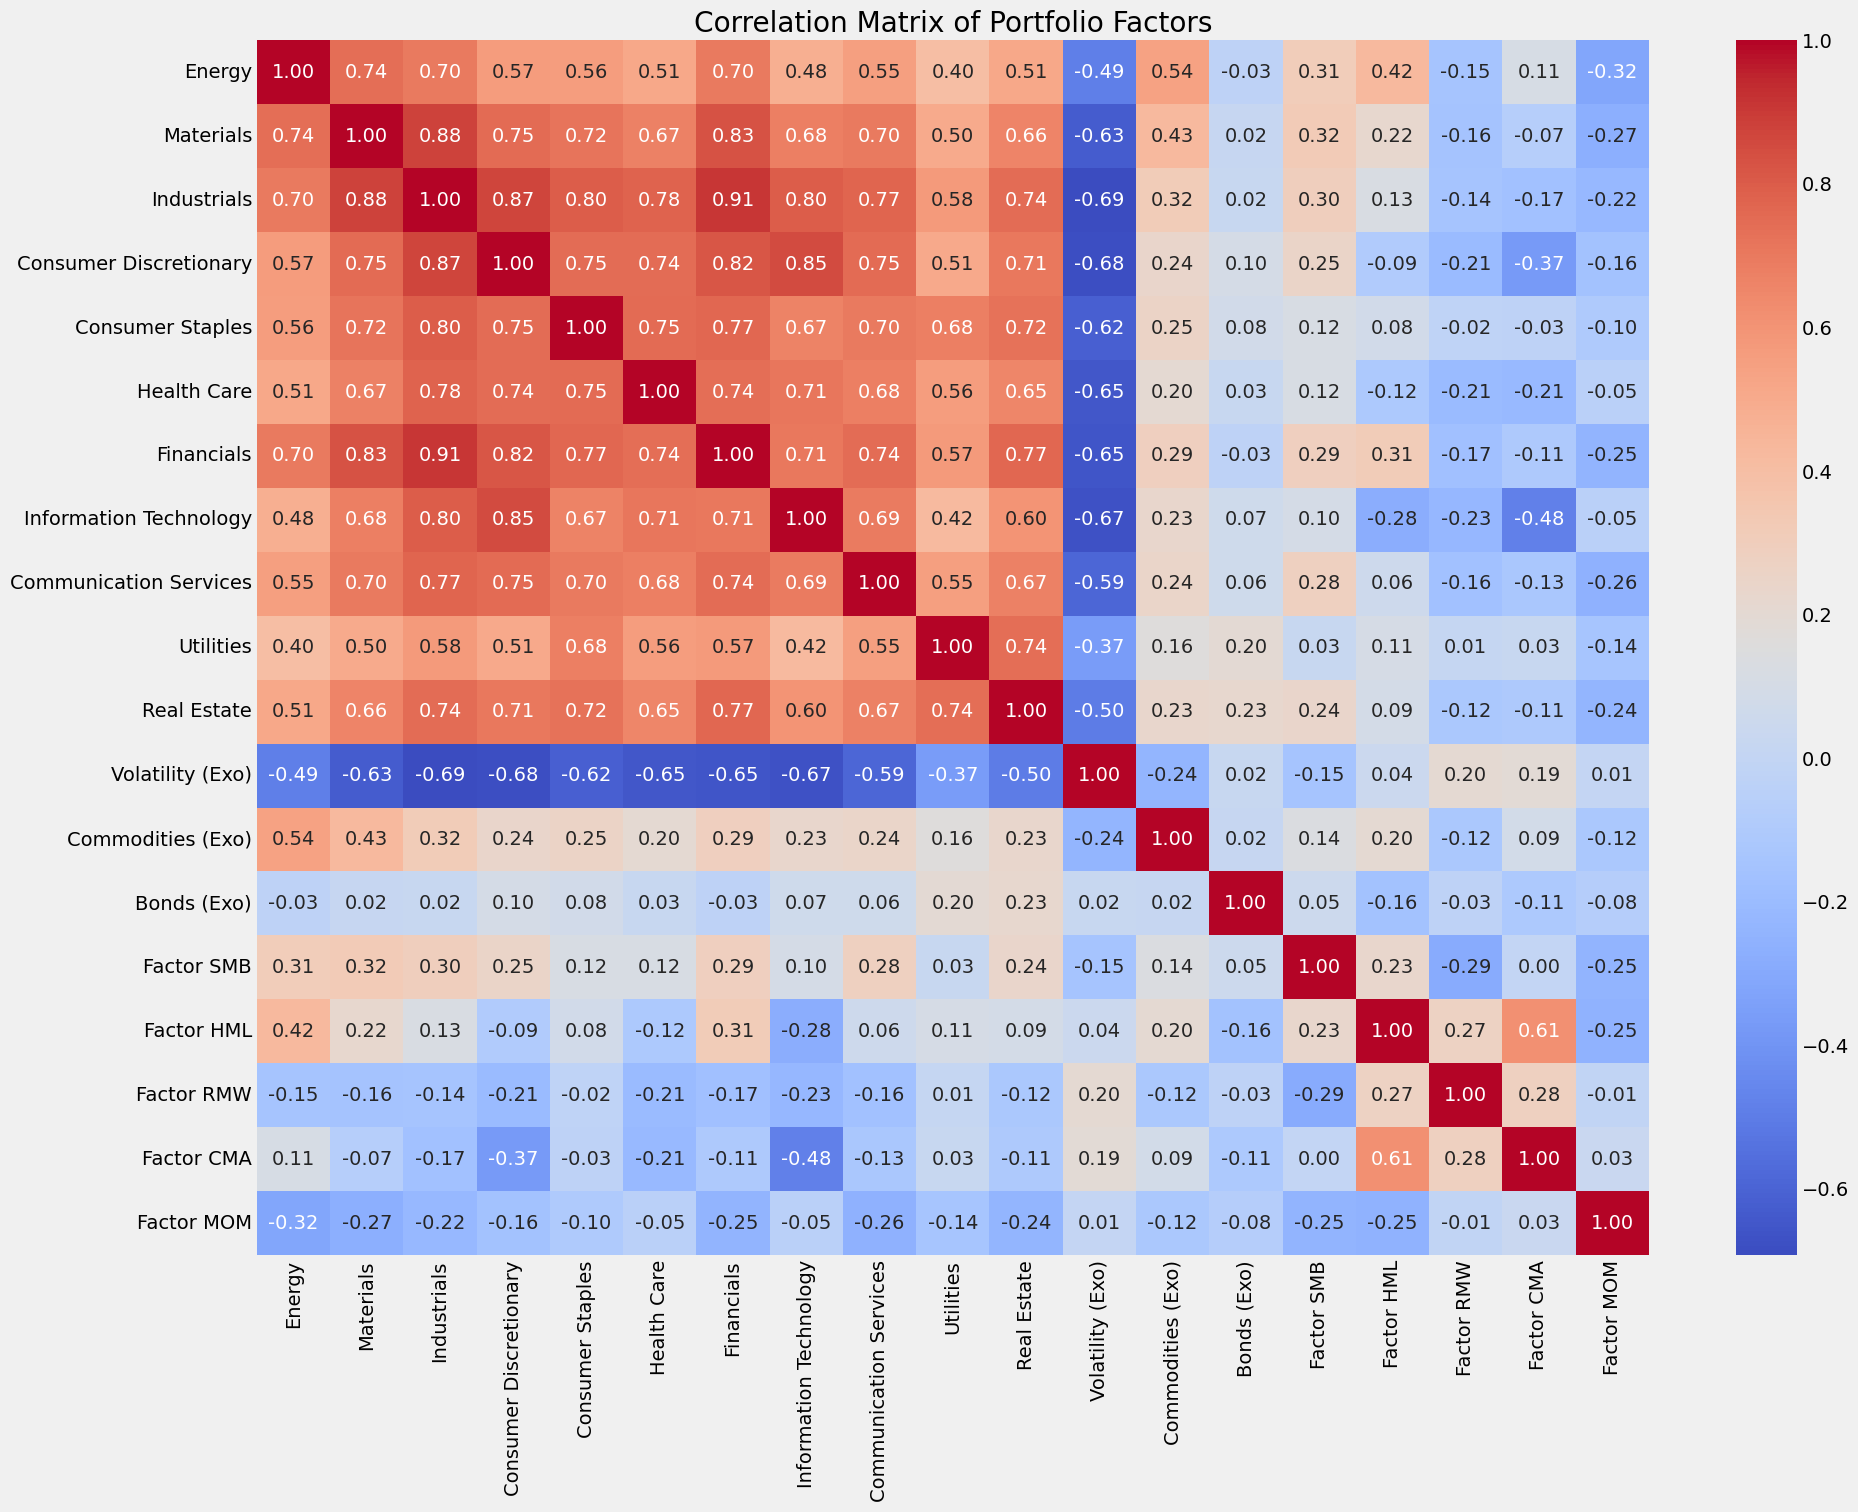

In [37]:
correlation_matrix = log_returns.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix of Portfolio Factors')
plt.show()

#### Fig. 2 - Rolling Beta vs Benchmark

In [38]:
# calculate rolling beta function
def calculate_rolling_beta(factor_returns, market_returns, window):
    return factor_returns.rolling(window=window).apply(
        lambda z: np.cov(z, market_returns.loc[z.index].squeeze())[0, 1] / np.var(market_returns.loc[z.index].squeeze()),
        raw=False
    )

In [39]:
# window over 1 year
window = 252

# number of factors 
num_factors = len(log_returns_back_testing.columns)

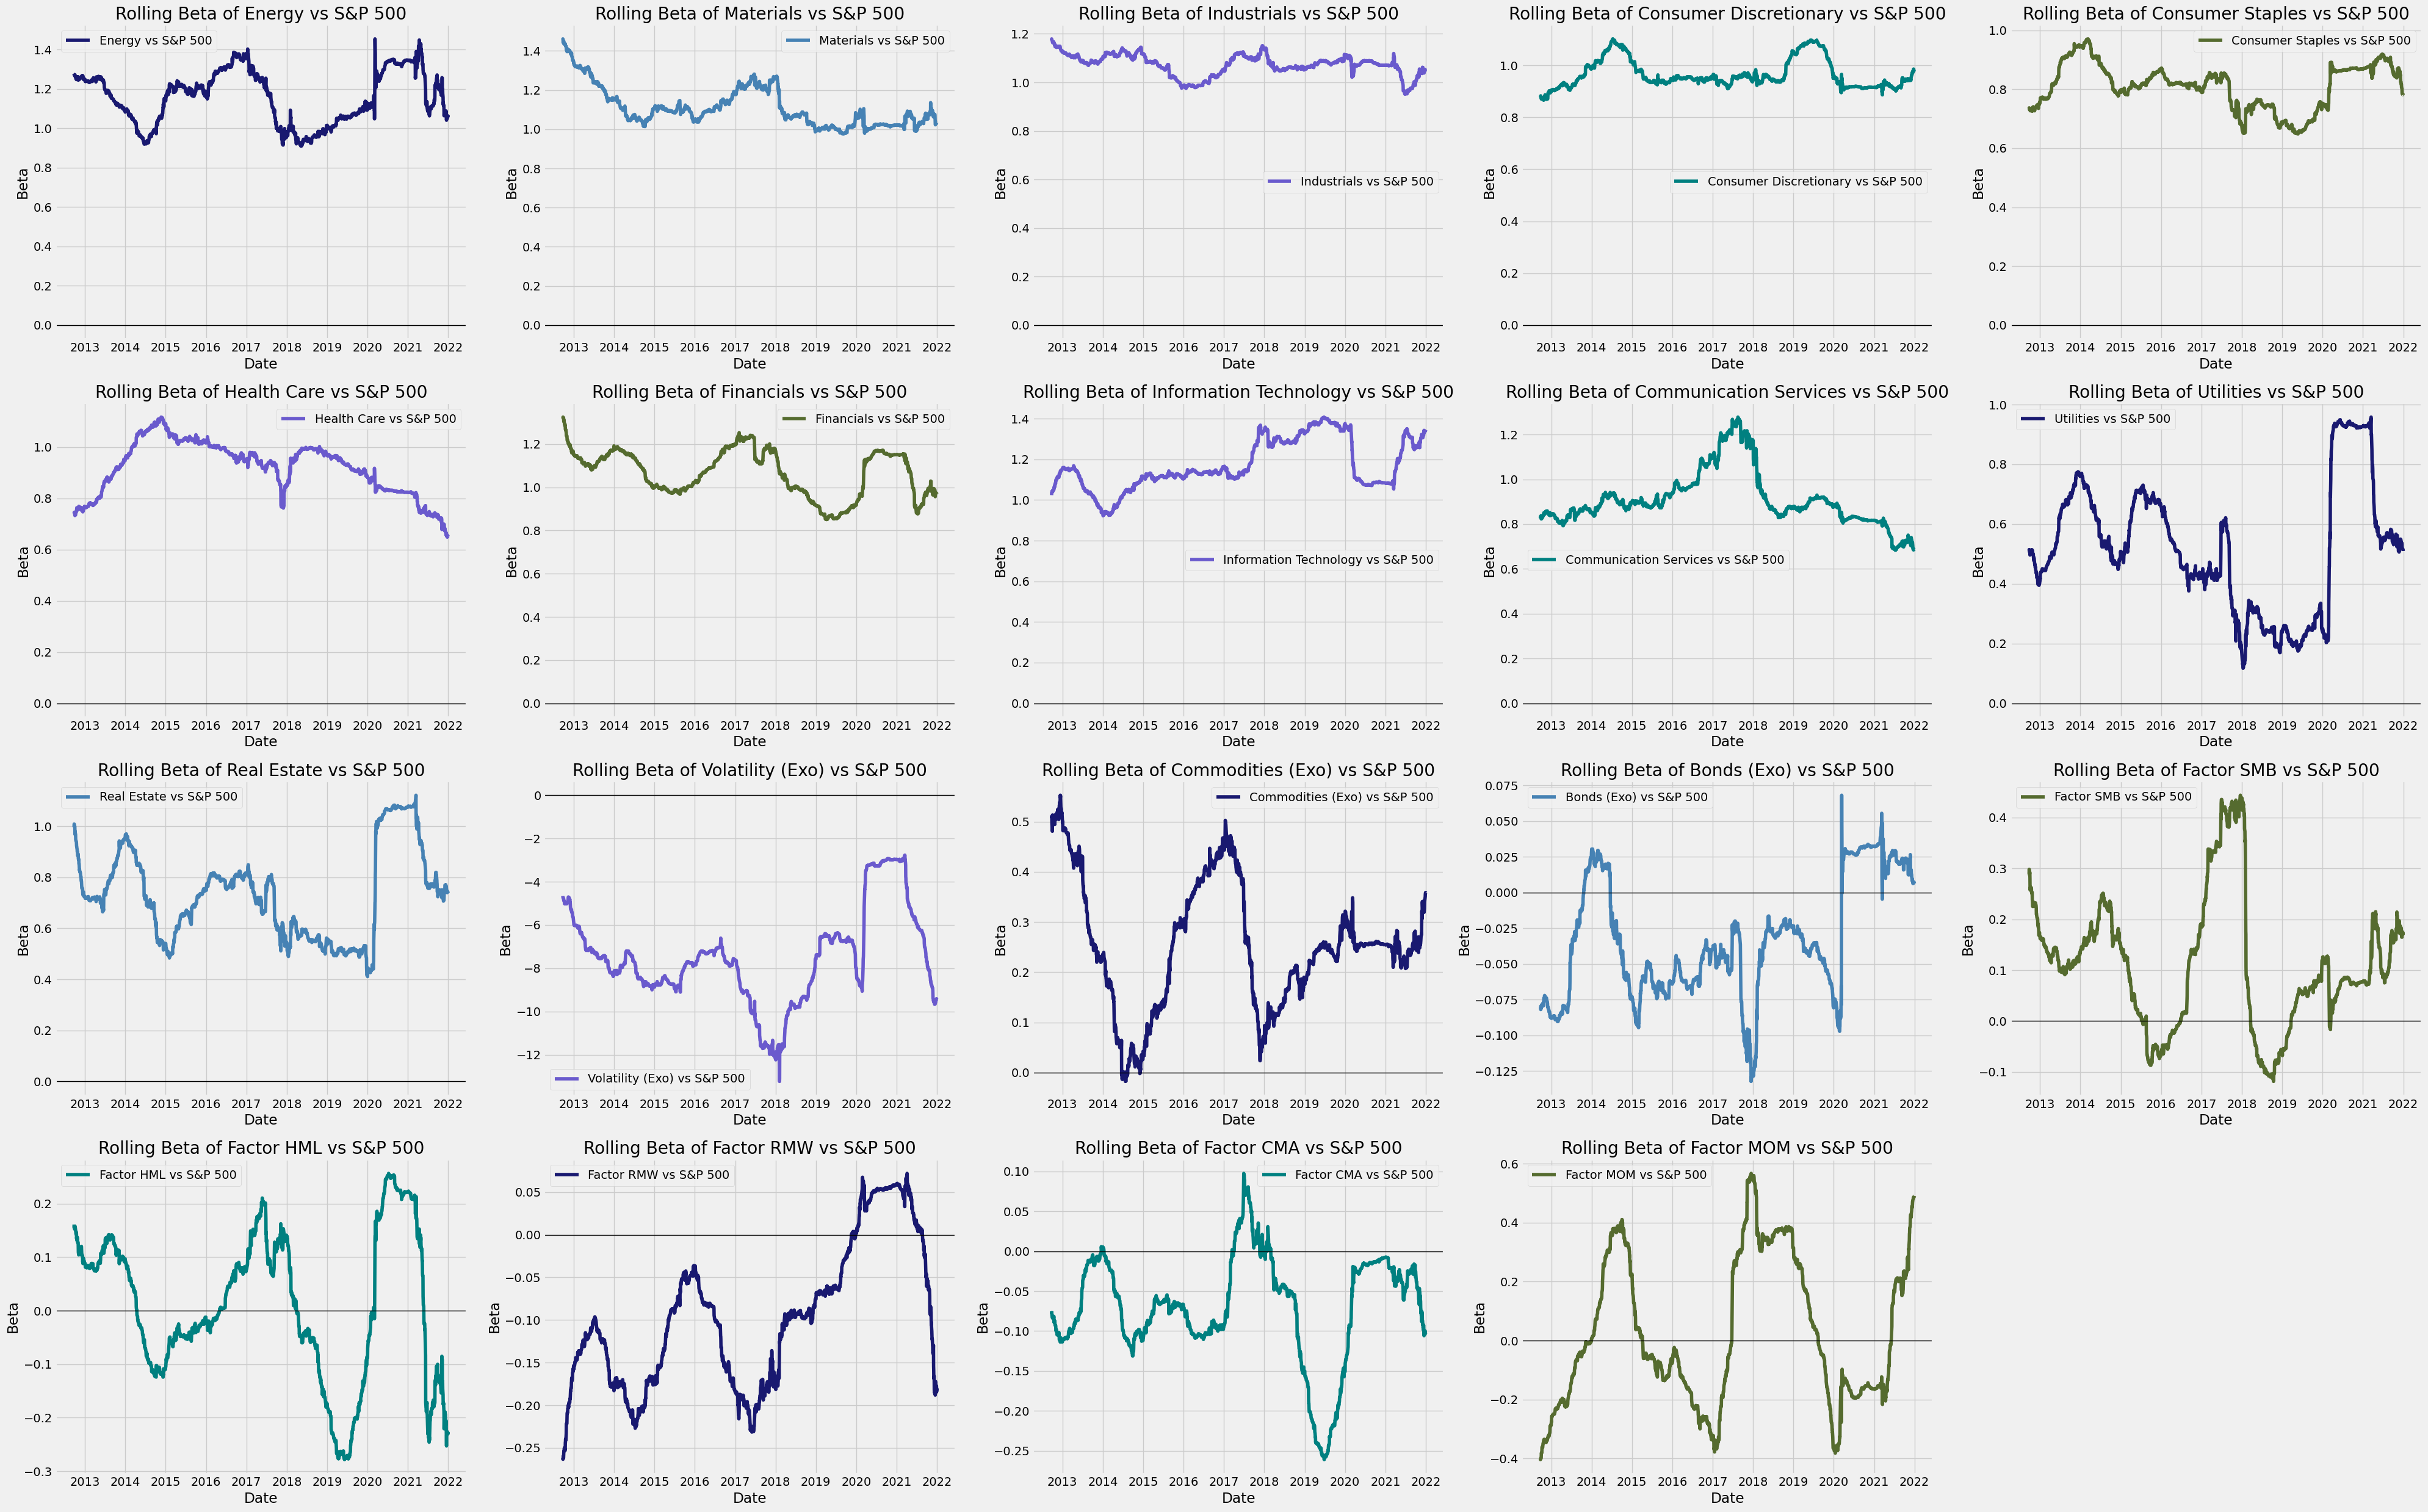

In [40]:
# grid layout
nrows = 4
ncols = 5

# subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
colours *= (len(log_returns_back_testing.columns) // len(colours)) + 1
random.shuffle(colours)

for i, column in enumerate(log_returns_back_testing.columns):
    rolling_beta = calculate_rolling_beta(log_returns_back_testing[column], benchmark_spx_500_back_testing.squeeze(), window)
    axes[i].plot(rolling_beta.index, rolling_beta, label=f'{column} vs S&P 500', color=colours[i % len(colours)])
    axes[i].axhline(0, color='black', linewidth=1)
    axes[i].set_title(f'Rolling Beta of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True)

# Hide the last empty subplot if necessary
if len(log_returns_back_testing.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#### Fig. 3 - Rolling Alpha vs Benchmark

In [41]:
# calculate rolling alpha
def calculate_rolling_alpha(factor_returns, market_returns, window):
    return factor_returns.rolling(window=window).apply(
        lambda z: np.polyfit(market_returns.loc[z.index].squeeze(), z, 1)[1],
        raw=False
    )

In [42]:
# window over 1 year
window = 252

# number of factors 
num_factors = len(log_returns_back_testing.columns)

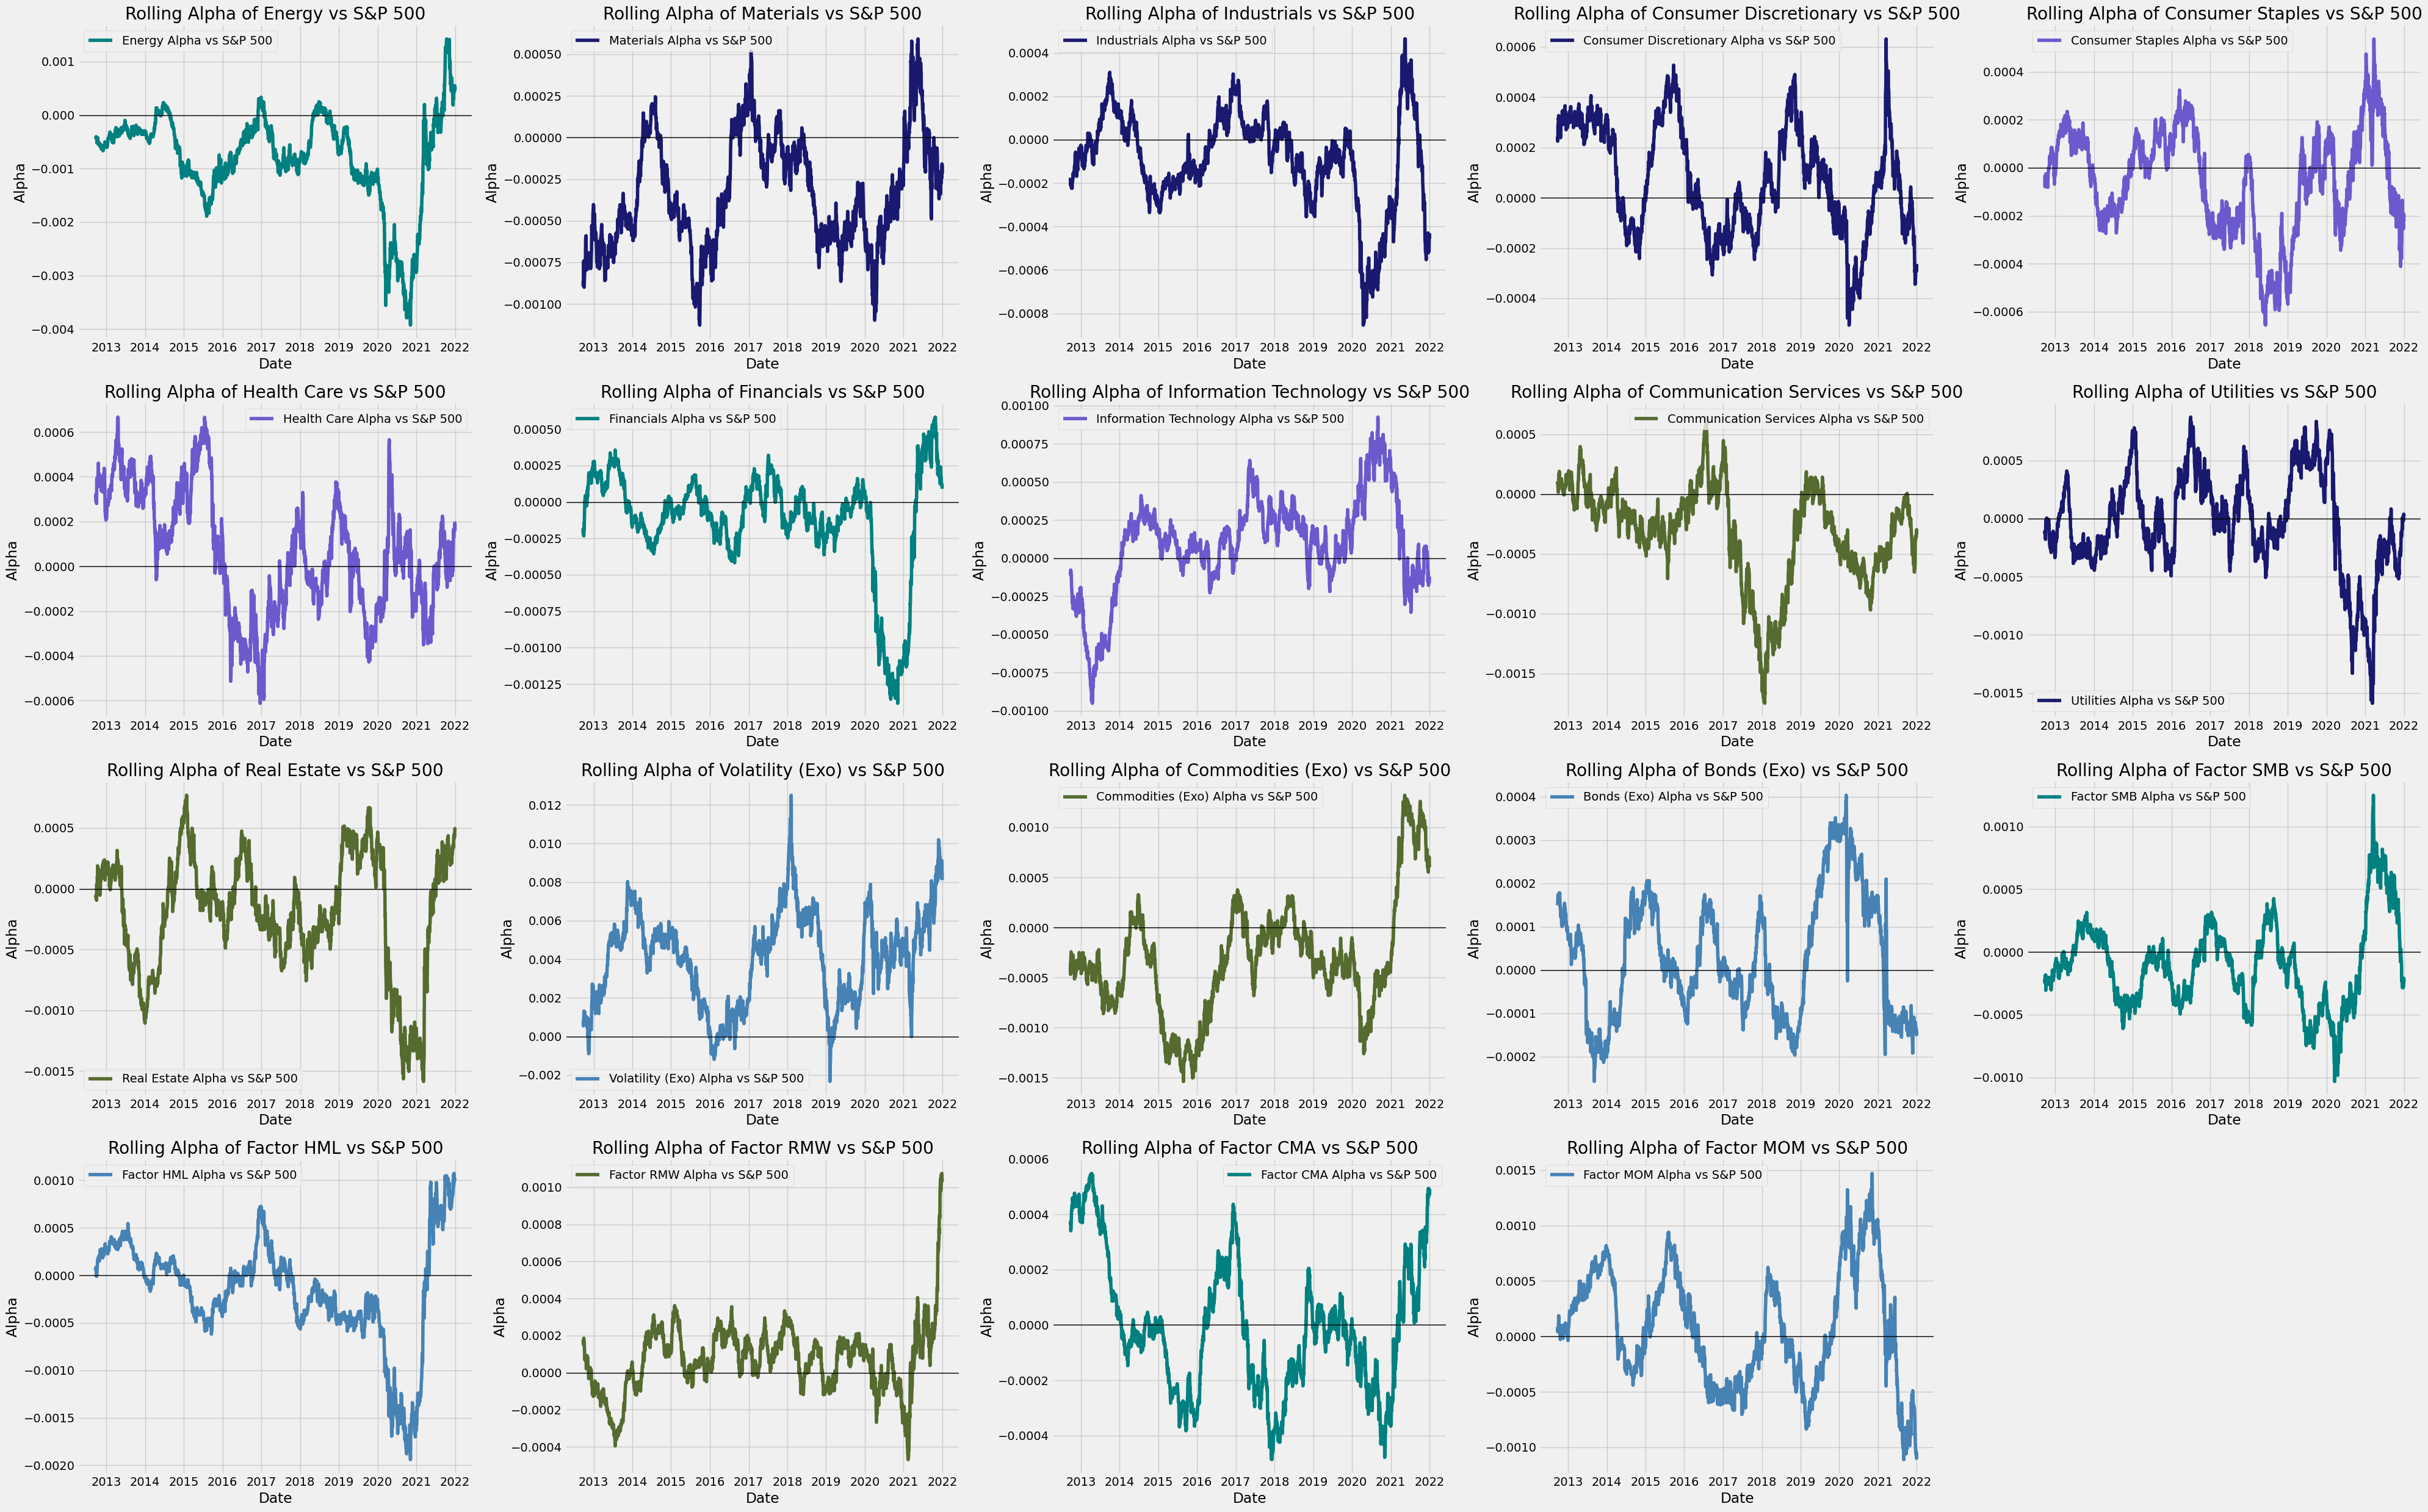

In [43]:
# Grid layout for subplots
nrows = 4
ncols = 5

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# Colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
colours *= (len(log_returns_back_testing.columns) // len(colours)) + 1
random.shuffle(colours)

# Loop over each factor to compute and plot rolling alpha
for i, column in enumerate(log_returns_back_testing.columns):
    rolling_alpha = calculate_rolling_alpha(log_returns_back_testing[column], benchmark_spx_500_back_testing.squeeze(), window)
    axes[i].plot(rolling_alpha.index, rolling_alpha, label=f'{column} Alpha vs S&P 500', color=colours[i % len(colours)])
    axes[i].axhline(0, color='black', linewidth=1)
    axes[i].set_title(f'Rolling Alpha of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Alpha')
    axes[i].legend()
    axes[i].grid(True)

# Hide the last empty subplot if necessary
if len(log_returns_back_testing.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#### Fig. 4 - Portfolio Factor Performance vs Benchmark

In [44]:
simple_returns_back_testing = np.exp(log_returns_back_testing) - 1

# calculate cumulative returns
cumulative_returns_back_testing = (1 + simple_returns_back_testing).cumprod() - 1
cumulative_benchmark_spx_500_back_testing = (1 + benchmark_spx_500_back_testing).cumprod() - 1

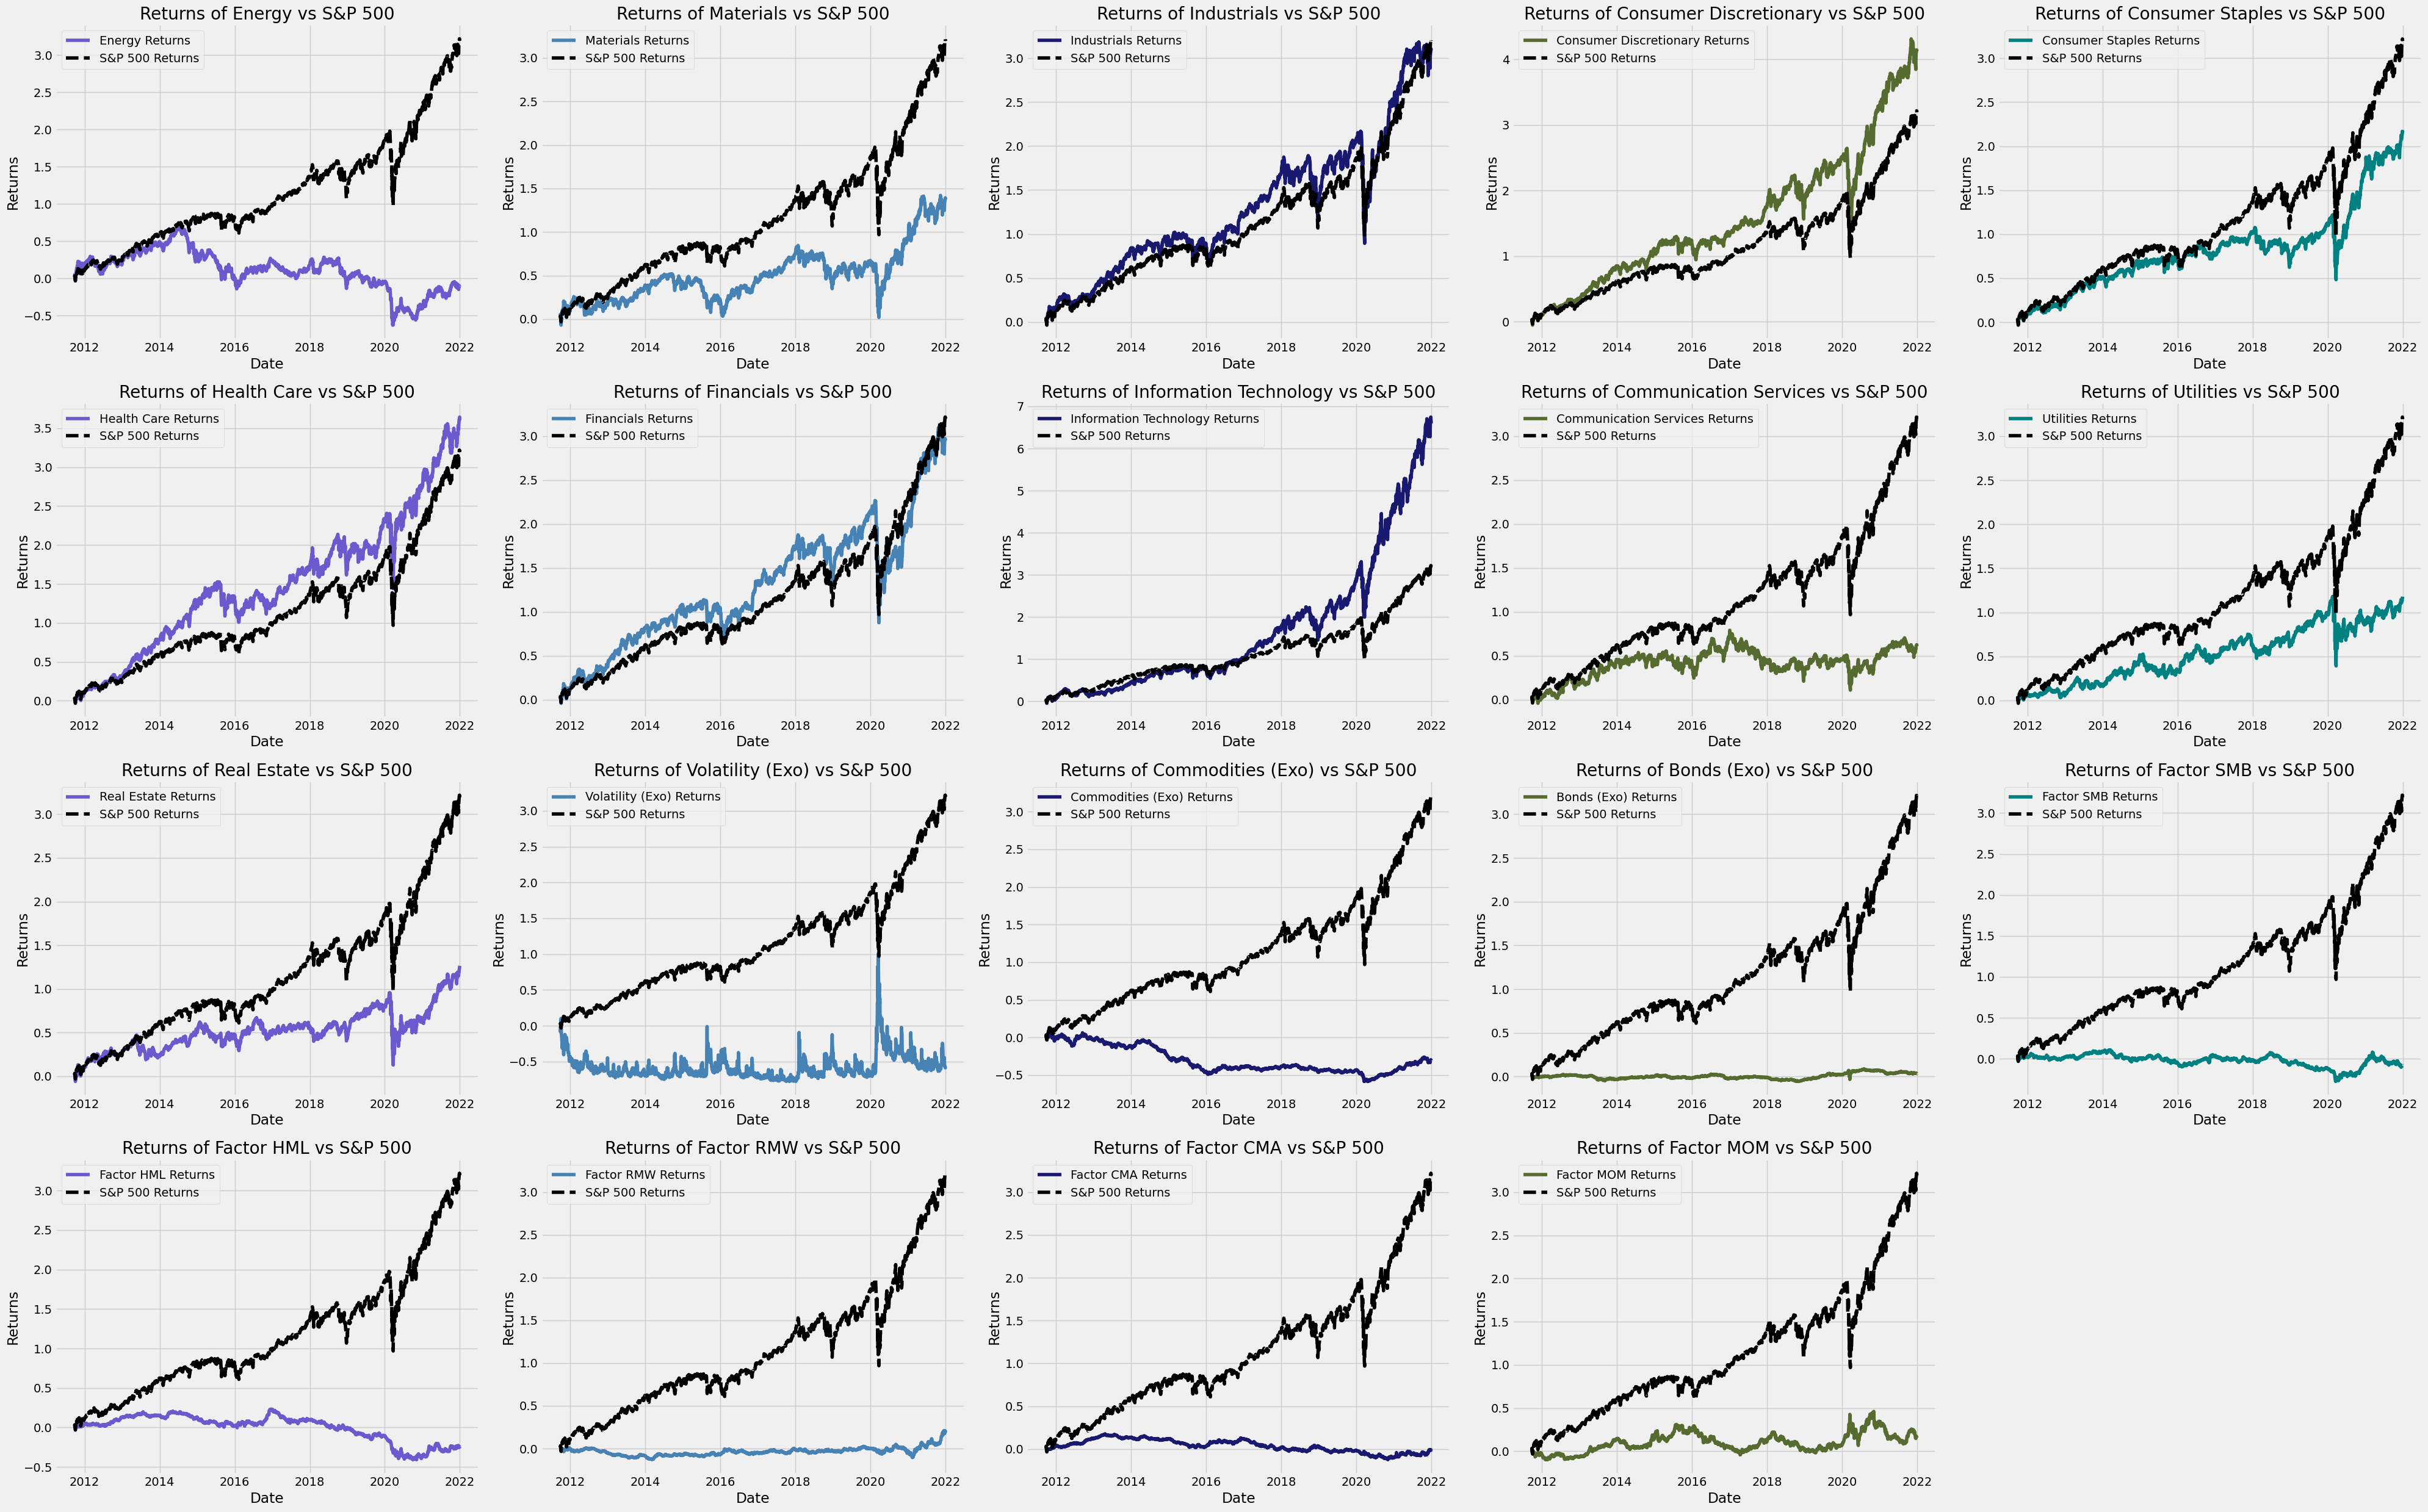

In [45]:
# dimensions of plot
nrows = 4
ncols = 5

# create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
random.shuffle(colours)

# plot factor returns vs benchmark
for i, column in enumerate(cumulative_returns_back_testing.columns):

    axes[i].plot(cumulative_returns_back_testing.index, cumulative_returns_back_testing[column], label=f'{column} Returns', color=colours[i % len(colours)])
    axes[i].plot(cumulative_benchmark_spx_500_back_testing.index, cumulative_benchmark_spx_500_back_testing, label='S&P 500 Returns', color='black', linestyle='--')
    axes[i].set_title(f'Returns of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Returns')
    axes[i].legend()
    axes[i].grid(True)

# hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Fig. 6 Adjusted Weights from S&P 500 per GICs Sector (2022) 

In [46]:
sector_weights_table = pd.DataFrame(sector_weights, columns=['Weights'])

sector_weights_table = sector_weights_table.rename_axis("Sector")

print(tabulate((sector_weights_table.mul(100).map('{:,.2f}%'.format)), headers='keys', tablefmt='pipe'))

| Sector                 | Weights   |
|:-----------------------|:----------|
| Energy                 | 3.40%     |
| Materials              | 2.39%     |
| Industrials            | 7.36%     |
| Consumer Discretionary | 10.86%    |
| Consumer Staples       | 5.70%     |
| Health Care            | 12.24%    |
| Financials             | 10.58%    |
| Information Technology | 25.85%    |
| Communication Services | 8.83%     |
| Utilities              | 2.39%     |
| Real Estate            | 2.39%     |


| Sector                 | Weights   |
|:-----------------------|:----------|
| Energy                 | 3.40%     |
| Materials              | 2.39%     |
| Industrials            | 7.36%     |
| Consumer Discretionary | 10.86%    |
| Consumer Staples       | 5.70%     |
| Health Care            | 12.24%    |
| Financials             | 10.58%    |
| Information Technology | 25.85%    |
| Communication Services | 8.83%     |
| Utilities              | 2.39%     |
| Real Estate            | 2.39%     |

#### Fig. 7 Implied Equilibrium Returns vs Expected Returns

In [47]:
implied_equilibrium_returns = bl_model.calculate_implied_equilibrium_returns().mul(252).mul(100)
implied_equilibrium_returns['Average Return'] = log_returns_back_testing.mean().mul(252).mul(100)

implied_equilibrium_returns['Avg. - Impl. Return'] = implied_equilibrium_returns['Implied Return'] - implied_equilibrium_returns['Average Return']

implied_equilibrium_returns = tabulate((implied_equilibrium_returns.map('{:,.2f}%'.format)), headers='keys', tablefmt='pipe')

Fig. 7 Implied Equilibrium Returns vs Expected Returns

|                        | Implied Return   | Average Return   | Adj. - Impl. Return   |
|:-----------------------|:-----------------|:-----------------|:----------------------|
| Energy                 | 6.77%            | -1.14%           | 7.91%                 |
| Materials              | 6.02%            | 8.51%            | -2.49%                |
| Industrials            | 5.89%            | 13.76%           | -7.86%                |
| Consumer Discretionary | 5.18%            | 15.94%           | -10.76%               |
| Consumer Staples       | 4.45%            | 11.28%           | -6.83%                |
| Health Care            | 4.72%            | 14.92%           | -10.20%               |
| Financials             | 6.05%            | 13.39%           | -7.34%                |
| Information Technology | 6.31%            | 19.77%           | -13.46%               |
| Communication Services | 4.90%            | 4.67%            | 0.24%                 |
| Utilities              | 3.57%            | 7.59%            | -4.02%                |
| Real Estate            | 4.88%            | 7.97%            | -3.09%                |
| Volatility (Exo)       | -29.10%          | -8.52%           | -20.58%               |
| Commodities (Exo)      | 1.58%            | -3.57%           | 5.16%                 |
| Bonds (Exo)            | -0.05%           | 0.33%            | -0.38%                |
| Factor SMB             | 0.74%            | -0.88%           | 1.62%                 |
| Factor HML             | 0.42%            | -2.71%           | 3.13%                 |
| Factor RMW             | -0.32%           | 1.79%            | -2.11%                |
| Factor CMA             | -0.35%           | -0.08%           | -0.27%                |
| Factor MOM             | -0.51%           | 1.40%            | -1.91%                |

#### Fig. 8 Comparing Subset Sector Implied Excess Return

In [48]:
# defensive
print(f'Consumer Staples - Subset Weight: {round((5.70 / (5.70 + 12.24)), 4):.2%}')
print(f'Healthcare - Subset Weight: {round((12.24 / (5.70 + 12.24)), 4):.2%}')
print()

print(f'Consumer Staples - Weighted Return: {(0.3177 * 0.0445):.2%}')
print(f'Healthcare - Weighted Return: {(0.6823 * 0.0472):.2%}')


print(f'Total: {((0.3177 * 0.0445) + (0.6823 * 0.0472)):.2%}')
print()

# cyclical
print(f'Consumer Discretionary - Subset Weight: {round((10.86 / (10.86 + 2.39)), 4):.2%}')
print(f'Materials - Subset Weight: {round((2.39 / (10.86 + 2.39)), 4):.2%}')
print()

print(f'Consumer Discretionary - Weighted Return: {(0.8196 * 0.0518):.2%}')
print(f'Materials - Weighted Return: {(0.1804 * 0.0602):.2%}')

print(f'Total: {((0.8196 * 0.0518) + (0.1804 * 0.0602)):.2%}')

Consumer Staples - Subset Weight: 31.77%
Healthcare - Subset Weight: 68.23%

Consumer Staples - Weighted Return: 1.41%
Healthcare - Weighted Return: 3.22%
Total: 4.63%

Consumer Discretionary - Subset Weight: 81.96%
Materials - Subset Weight: 18.04%

Consumer Discretionary - Weighted Return: 4.25%
Materials - Weighted Return: 1.09%
Total: 5.33%


#### Fig. 9 Pre-and-Post Optimisation Portfolio Weights

In [54]:
# returns
adjusted_returns_vector = bl_model.calculate_views_adjusted_returns().mul(252)
implied_returns_vector = bl_model.calculate_implied_equilibrium_returns().mul(252)

# weights
adjusted_weights_vector = bl_model.calculate_unconstrained_mv_optimisation()
equilibrium_weights_vector = pd.DataFrame(equilibrium_weights, columns=['Equilibrium Weights'])

pre_post_optimisation = pd.concat([adjusted_returns_vector, 
                         implied_returns_vector,
                         adjusted_weights_vector,
                         equilibrium_weights_vector], axis=1)


# delta weights and return
pre_post_optimisation['Adj. - Impl. Return'] = pre_post_optimisation['Adjusted Return'] - pre_post_optimisation['Implied Return']
pre_post_optimisation['Adj. - Eq. Weights'] = pre_post_optimisation['Adjusted Weights'] - pre_post_optimisation['Equilibrium Weights']

# column order
pre_post_optimisation = pre_post_optimisation[['Adjusted Return', 'Implied Return', 'Adj. - Impl. Return', 'Adjusted Weights', 'Equilibrium Weights', 'Adj. - Eq. Weights']]

pre_post_optimisation = tabulate((pre_post_optimisation.map('{:,.2%}'.format)), headers='keys', tablefmt='pipe')

Fig. 9 - Pre-and-Post Optimisation Portfolio Weights

|                        | Adjusted Return   | Implied Return   | Adj. - Impl. Return   | Adjusted Weights   | Equilibrium Weights   | Adj. - Eq. Weights   |
|:-----------------------|:------------------|:-----------------|:----------------------|:-------------------|:----------------------|:---------------------|
| Energy                 | 6.35%             | 6.77%            | -0.42%                | 4.19%              | 3.40%                 | 0.78%                |
| Materials              | 5.60%             | 6.02%            | -0.42%                | -3.89%             | 2.39%                 | -6.28%               |
| Industrials            | 5.58%             | 5.89%            | -0.31%                | 7.30%              | 7.36%                 | -0.06%               |
| Consumer Discretionary | 4.73%             | 5.18%            | -0.45%                | -17.67%            | 10.86%                | -28.53%              |
| Consumer Staples       | 4.38%             | 4.45%            | -0.07%                | 16.68%             | 5.70%                 | 10.98%               |
| Health Care            | 4.96%             | 4.72%            | 0.25%                 | 35.81%             | 12.24%                | 23.57%               |
| Financials             | 5.77%             | 6.05%            | -0.28%                | 12.31%             | 10.58%                | 1.73%                |
| Information Technology | 5.96%             | 6.31%            | -0.34%                | 23.82%             | 25.85%                | -2.03%               |
| Communication Services | 4.72%             | 4.90%            | -0.19%                | 8.76%              | 8.83%                 | -0.07%               |
| Utilities              | 3.66%             | 3.57%            | 0.09%                 | 2.37%              | 2.39%                 | -0.02%               |
| Real Estate            | 4.76%             | 4.88%            | -0.12%                | 2.37%              | 2.39%                 | -0.02%               |
| Volatility (Exo)       | -27.69%           | -29.10%          | 1.41%                 | 0.99%              | 1.00%                 | -0.01%               |
| Commodities (Exo)      | 1.44%             | 1.58%            | -0.15%                | 0.99%              | 1.00%                 | -0.01%               |
| Bonds (Exo)            | -0.06%            | -0.05%           | -0.01%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor SMB             | 0.58%             | 0.74%            | -0.16%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor HML             | 0.29%             | 0.42%            | -0.13%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor RMW             | -0.35%            | -0.32%           | -0.04%                | 0.99%              | 1.00%                 | -0.01%               |
| Factor CMA             | -0.31%            | -0.35%           | 0.04%                 | 0.99%              | 1.00%                 | -0.01%               |
| Factor MOM             | -0.42%            | -0.51%           | 0.09%                 | 0.99%              | 1.00%                 | -0.01%               |

#### Fig. 10 Optimisation - Trustee vs Market vs Kelly

In [55]:
# risk aversions
bl_model_kelly = BlackLittermanModel(equilibrium_weights, log_returns_back_testing, risk_aversion_dict['Kelly'], P, Q)
bl_model_trustee = BlackLittermanModel(equilibrium_weights, log_returns_back_testing, risk_aversion_dict['Trustee'], P, Q)

unconstrained_weights_vector_kelly = bl_model_kelly.calculate_unconstrained_mv_optimisation().rename(columns={'Adjusted Weights': 'Kelly Weights'})
unconstrained_weights_vector_trustee = bl_model_trustee.calculate_unconstrained_mv_optimisation().rename(columns={'Adjusted Weights': 'Trustee Weights'})


risk_aversion_comparision = pd.concat([equilibrium_weights_vector,
                                       unconstrained_weights_vector_kelly, 
                                       adjusted_weights_vector.rename(columns={'Adjusted Weights': 'Market Weights'}), 
                                       unconstrained_weights_vector_trustee
                                       ], axis=1)

risk_aversion_comparision = tabulate((risk_aversion_comparision.map('{:.2%}'.format)), headers='keys', tablefmt='pipe')

|                        | Equilibrium Weights   | Kelly Weights   | Market Weights   | Trustee Weights   |
|:-----------------------|:----------------------|:----------------|:-----------------|:------------------|
| Energy                 | 3.40%                 | 97.83%          | 4.19%            | -9.07%            |
| Materials              | 2.39%                 | -21.66%         | -3.89%           | -1.37%            |
| Industrials            | 7.36%                 | 0.16%           | 7.30%            | 8.31%             |
| Consumer Discretionary | 10.86%                | -98.40%         | -17.67%          | -6.24%            |
| Consumer Staples       | 5.70%                 | 38.36%          | 16.68%           | 13.61%            |
| Health Care            | 12.24%                | 82.39%          | 35.81%           | 29.22%            |
| Financials             | 10.58%                | -24.12%         | 12.31%           | 17.47%            |
| Information Technology | 25.85%                | 24.94%          | 23.82%           | 23.67%            |
| Communication Services | 8.83%                 | 0.20%           | 8.76%            | 9.97%             |
| Utilities              | 2.39%                 | 0.05%           | 2.37%            | 2.70%             |
| Real Estate            | 2.39%                 | 0.05%           | 2.37%            | 2.70%             |
| Volatility (Exo)       | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Commodities (Exo)      | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Bonds (Exo)            | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor SMB             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor HML             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor RMW             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor CMA             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |
| Factor MOM             | 1.00%                 | 0.02%           | 0.99%            | 1.13%             |

#### Fig 11. Constrained Optimisation

In [56]:
# constrained
constrained_weights_vector = bl_model.calculate_constrained_mv_optimisation()

constained_vs_unconstrained_comparision = pd.concat([equilibrium_weights_vector,
                                                     adjusted_weights_vector.rename(columns={'Adjusted Weights': 'Unconstrained Adjusted Weights'}),
                                                     constrained_weights_vector
                                                    ], axis=1)

# delta constrained vs unconstrained
constained_vs_unconstrained_comparision['Difference'] = constained_vs_unconstrained_comparision['Constrained Adjusted Weights'] - constained_vs_unconstrained_comparision['Unconstrained Adjusted Weights']

constained_vs_unconstrained_comparision = tabulate((constained_vs_unconstrained_comparision.map('{:.2%}'.format)), headers='keys', tablefmt='pipe')

Fig 11. Constrained Optimisation Portfolio Weights

|                        | Equilibrium Weights   | Unconstrained Adjusted Weights   | Constrained Adjusted Weights   | Difference Weights   |
|:-----------------------|:----------------------|:---------------------------------|:-------------------------------|:---------------------|
| Energy                 | 3.40%                 | 4.19%                            | 5.12%                          | 0.93%                |
| Materials              | 2.39%                 | -3.89%                           | 0.00%                          | 3.89%                |
| Industrials            | 7.36%                 | 7.30%                            | 0.08%                          | -7.22%               |
| Consumer Discretionary | 10.86%                | -17.67%                          | 0.00%                          | 17.67%               |
| Consumer Staples       | 5.70%                 | 16.68%                           | 14.63%                         | -2.05%               |
| Health Care            | 12.24%                | 35.81%                           | 36.00%                         | 0.19%                |
| Financials             | 10.58%                | 12.31%                           | 9.75%                          | -2.56%               |
| Information Technology | 25.85%                | 23.82%                           | 17.63%                         | -6.19%               |
| Communication Services | 8.83%                 | 8.76%                            | 6.76%                          | -2.00%               |
| Utilities              | 2.39%                 | 2.37%                            | 3.50%                          | 1.12%                |
| Real Estate            | 2.39%                 | 2.37%                            | 1.27%                          | -1.10%               |
| Volatility (Exo)       | 1.00%                 | 0.99%                            | 0.95%                          | -0.04%               |
| Commodities (Exo)      | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Bonds (Exo)            | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor SMB             | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor HML             | 1.00%                 | 0.99%                            | 3.40%                          | 2.41%                |
| Factor RMW             | 1.00%                 | 0.99%                            | 0.00%                          | -0.99%               |
| Factor CMA             | 1.00%                 | 0.99%                            | 0.71%                          | -0.28%               |
| Factor MOM             | 1.00%                 | 0.99%                            | 0.19%                          | -0.80%               |

#### Fig 12. Tracking Error Optimisation

In [57]:
bl_model_te_low = BlackLittermanModel(equilibrium_weights, log_returns, risk_aversion_dict['Market'], P, Q, tracking_error_target=0.0000009)
bl_model_te_neutral = BlackLittermanModel(equilibrium_weights, log_returns, risk_aversion_dict['Market'], P, Q, tracking_error_target=0.00001)
bl_model_te_high = BlackLittermanModel(equilibrium_weights, log_returns, risk_aversion_dict['Market'], P, Q, tracking_error_target=0.0001)

tracking_error_weights_low = bl_model_te_low.calculate_tracking_error_optimisation().rename(columns={'TE Constrained Adjusted Weights': 'Tracking Error - Low Tolerance'})
tracking_error_weights_netural = bl_model_te_neutral.calculate_tracking_error_optimisation().rename(columns={'TE Constrained Adjusted Weights': 'Tracking Error - Neutral Tolerance'})
tracking_error_weights_high = bl_model_te_high.calculate_tracking_error_optimisation().rename(columns={'TE Constrained Adjusted Weights': 'Tracking Error - High Tolerance'})

tracking_error_comparision = pd.concat([adjusted_returns_vector, equilibrium_weights_vector, tracking_error_weights_low, 
                                        tracking_error_weights_netural, tracking_error_weights_high], axis=1)

tracking_error_comparision = tabulate((tracking_error_comparision.map('{:.2%}'.format)), headers='keys', tablefmt='pipe')

Fig. 12 Tracking Error Constrained Optimisation

|                        | Adjusted Return   | Equilibrium Weights   | Tracking Error - Low Tolerance   | Tracking Error - Neutral Tolerance   | Tracking Error - High Tolerance   |
|:-----------------------|:------------------|:----------------------|:---------------------------------|:-------------------------------------|:----------------------------------|
| Energy                 | 6.35%             | 3.40%                 | 3.88%                            | 5.25%                                | 8.64%                             |
| Materials              | 5.60%             | 2.39%                 | 2.72%                            | 3.63%                                | 5.95%                             |
| Industrials            | 5.58%             | 7.36%                 | 7.63%                            | 8.36%                                | 10.27%                            |
| Consumer Discretionary | 4.73%             | 10.86%                | 11.03%                           | 11.47%                               | 12.69%                            |
| Consumer Staples       | 4.38%             | 5.70%                 | 5.82%                            | 6.13%                                | 6.96%                             |
| Health Care            | 4.96%             | 12.24%                | 12.33%                           | 12.53%                               | 13.15%                            |
| Financials             | 5.77%             | 10.58%                | 10.89%                           | 11.75%                               | 13.93%                            |
| Information Technology | 5.96%             | 25.85%                | 26.03%                           | 26.45%                               | 27.68%                            |
| Communication Services | 4.72%             | 8.83%                 | 9.02%                            | 9.54%                                | 10.89%                            |
| Utilities              | 3.66%             | 2.39%                 | 2.56%                            | 3.02%                                | 4.19%                             |
| Real Estate            | 4.76%             | 2.39%                 | 2.67%                            | 3.45%                                | 5.40%                             |
| Volatility (Exo)       | -27.69%           | 1.00%                 | 0.04%                            | -2.03%                               | -8.92%                            |
| Commodities (Exo)      | 1.44%             | 1.00%                 | 0.93%                            | 0.72%                                | 0.27%                             |
| Bonds (Exo)            | -0.06%            | 1.00%                 | 0.74%                            | -0.07%                               | -1.92%                            |
| Factor SMB             | 0.58%             | 1.00%                 | 0.83%                            | 0.31%                                | -0.86%                            |
| Factor HML             | 0.29%             | 1.00%                 | 0.88%                            | 0.52%                                | -0.30%                            |
| Factor RMW             | -0.35%            | 1.00%                 | 0.71%                            | -0.17%                               | -2.22%                            |
| Factor CMA             | -0.31%            | 1.00%                 | 0.73%                            | -0.09%                               | -1.99%                            |
| Factor MOM             | -0.42%            | 1.00%                 | 0.57%                            | -0.75%                               | -3.81%                            |

#### Fig. 13 - Cumulative Portfolio Performance

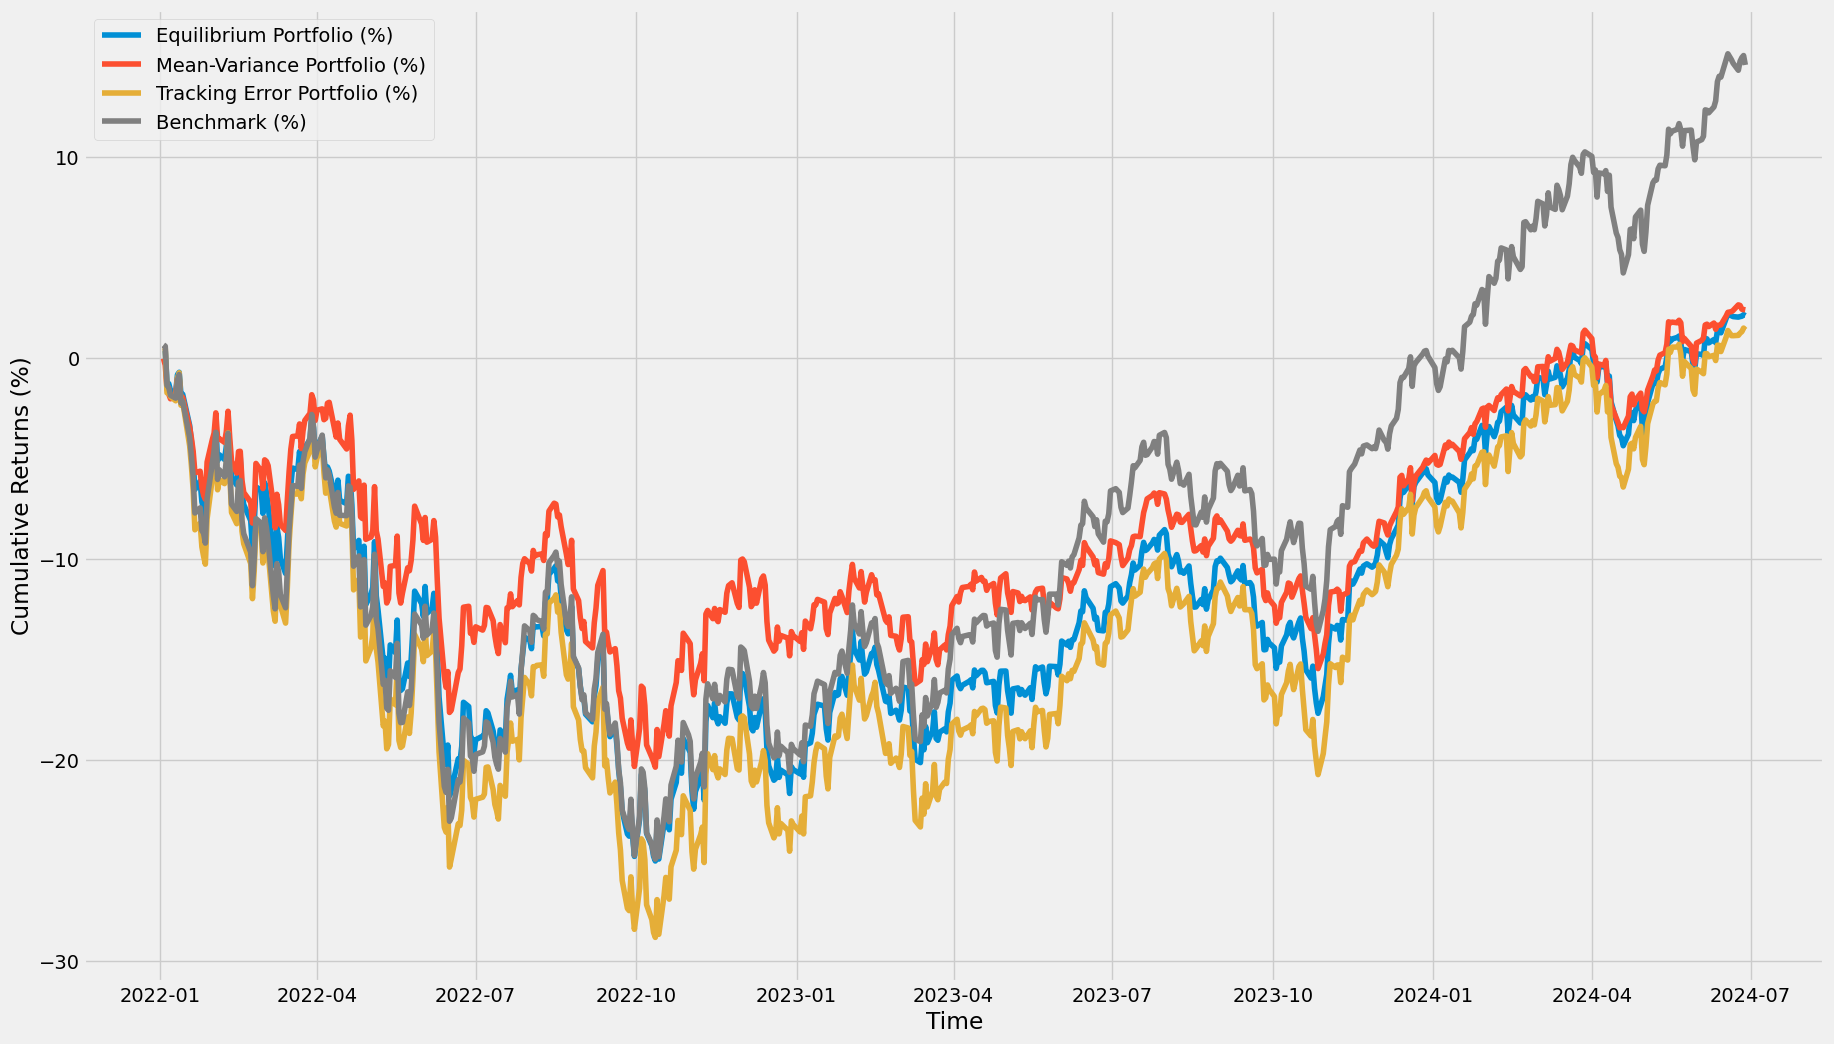

In [53]:
post_optimisation_index = common_index[common_index >= '2022-01-01']

# filter for index
log_returns_live_performance = log_returns.loc[post_optimisation_index]
benchmark_spx_500_live_performance= benchmark_spx_500.loc[post_optimisation_index]

# equilibrium_portfolio 
equilibrium_portfolio_daily_returns = log_returns_live_performance.dot(equilibrium_weights.values)
equilibrium_portfolio_cumulative_returns = ((1 + equilibrium_portfolio_daily_returns).cumprod() - 1) * 100

# constrained mean-variance
constrained_portfolio_daily_returns = log_returns_live_performance.dot(constrained_weights_vector.values)
constrained_portfolio_cumulative_returns = ((1 + constrained_portfolio_daily_returns).cumprod() - 1 )* 100

# neutral tracking error weights
tracking_error_portfolio_daily_returns = log_returns_live_performance.dot(tracking_error_weights_netural.values)
tracking_error_portfolio_cumulative_returns = ((1 + tracking_error_portfolio_daily_returns).cumprod() - 1) * 100

# benchmark
benchmark_spx_500_live_performance_cumulative = ((1 + benchmark_spx_500_live_performance).cumprod() - 1) * 100

# Plot the cumulative returns for all portfolios
plt.figure(figsize=(20, 12))
plt.plot(equilibrium_portfolio_cumulative_returns, label='Equilibrium Portfolio (%)')
plt.plot(constrained_portfolio_cumulative_returns, label='Mean-Variance Portfolio (%)')
plt.plot(tracking_error_portfolio_cumulative_returns, label='Tracking Error Portfolio (%)')
plt.plot(benchmark_spx_500_live_performance_cumulative, label='Benchmark (%)', color='grey')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.grid(True)
plt.show()